# Tutorial 3: parameters tuning guide
This tutorial shows the different choices of choosing DDN 3.0 hyper-parameters using data driven or probability based methods.

It is important to note that the most suitable choice of $\lambda_1$ and $\lambda_2$ relies on domain knowledge.
We advise user to choose a range of parameters and abserve the resulting networks to determine the parameters.

Nonetheless, this tuturial can be useful in providing sometimes tools in choosing $\lambda_1$ and $\lambda_2$.

We begin with importing some modules. The `parameter_tuning` module contains functions for tuning $\lambda_1$ and $\lambda_2$.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from ddn3 import tools, simulation, parameter_tuning

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We again generate a synthetic data. The data is the same as used in previous tutorials, except that we only shuffle 3 edges here, and uses less sample sizes.

In [18]:
n_node = 40
g1_prec, g2_prec = simulation.create_pair_graph(n_node=n_node, corr=0.75, n_shuf=3)

g1_cov, _ = simulation.create_cov_prec_mat(g1_prec)
g2_cov, _ = simulation.create_cov_prec_mat(g2_prec)

dat1 = tools.gen_mv(g1_cov, 40)
dat2 = tools.gen_mv(g2_cov, 40)

We need to initialize the cross validation object.
Here we set the number of cross validation to 10, and the ratio of data used for training to be 50%. With this setting, we do repeated two-fold cross validation.
Technically, after we estimate the network, for each node, we re-estimate the coefficients using its neighboring nodes only, and calculate the reconstruction error in the validation data.

Optionally, users can change the range of $\lambda_1$ and $\lambda_2$ values for seaching.

Below we will discuss five different choices of choosing $\lambda_1$ and $\lambda_2$.
They have quite different computational costs. For example, the method that perform grid search cross validation for $\lambda_1$ and $\lambda_2$ takes much longer time than methods that rely on two closed form equations.
Generally, the former one could be more accurate.

Instead of doing grid search cross validation on $\lambda_1$ and $\lambda_2$, it is also possible to do cross validation on $\lambda_1$ or $\lambda_2$ only, and rely on closed-form statistical equations for the other parameters. 

For smaller networks, it is better to just use grid search cross validation (option 1).
For larger ones, it is advised to use cross validation for $\lambda_1$, and cross validation or closed form equation for $\lambda_2$ (option 2 or option 3).
The closed form equaiton for $\lambda_1$ is not robust.

In [19]:
dp = parameter_tuning.DDNParameterSearch(dat1, dat2, n_cv=10, ratio_validation=0.5)

## Option 1: Grid search CV for $\lambda_1$ and $\lambda_2$
This is the most time consuming option, which searches a grid of $\lambda_1$ and $\lambda_2$.

In [20]:
val_err_0, l1_0, l2_0 = dp.fit("cv_joint")
print(f"lambda1={l1_0} lambda2={l2_0}")

resi
Repeat ============ 0
Repeat ============ 1
Repeat ============ 2
Repeat ============ 3
Repeat ============ 4
Repeat ============ 5
Repeat ============ 6
Repeat ============ 7
Repeat ============ 8
Repeat ============ 9
8 6
l1_org, l2_org  0.45 0.17500000000000002
8 7
l1, l2  0.45 0.2
lambda1=0.45 lambda2=0.2


The cross validation results can be visualized for all combinations of $\lambda_1$ and $\lambda_2$.

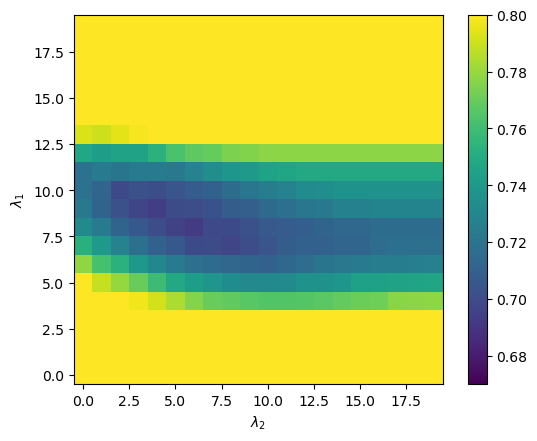

In [27]:
parameter_tuning.plot_error_2d(val_err_0, cmin=0.67, cmax=0.8)

## Option 2: CV for $\lambda_1$, then CV for $\lambda_2$
We first use cros validation for $\lambda_1$, then based on the chosen $\lambda_1$, we do cross validation on $\lambda_2$.

In [22]:
val_err_1, l1_1, l2_1 = dp.fit("cv_sequential")
print(f"lambda1={l1_1} lambda2={l2_1}")

resi
Repeat ============ 0
Repeat ============ 1
Repeat ============ 2
Repeat ============ 3
Repeat ============ 4
Repeat ============ 5
Repeat ============ 6
Repeat ============ 7
Repeat ============ 8
Repeat ============ 9
resi
Repeat ============ 0
Repeat ============ 1
Repeat ============ 2
Repeat ============ 3
Repeat ============ 4
Repeat ============ 5
Repeat ============ 6
Repeat ============ 7
Repeat ============ 8
Repeat ============ 9
lambda1=0.6500000000000001 lambda2=0.1


We can also plot the cross validation results. First figure is for $\lambda_1$, and the second for $\lambda_2$. 
The red bars means the standard error of the mean.

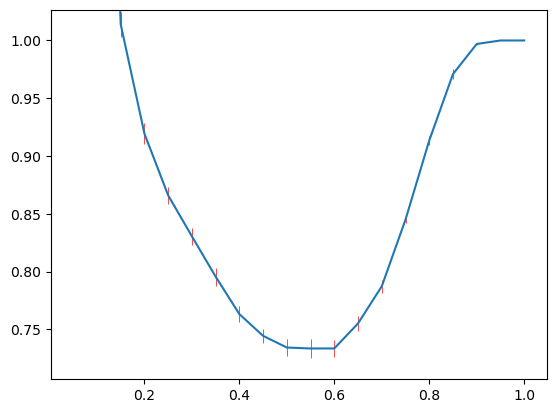

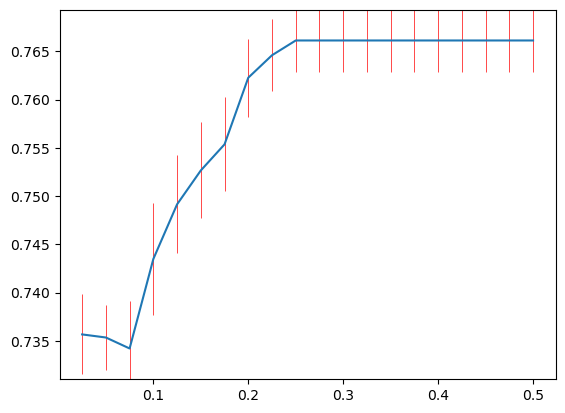

In [23]:
parameter_tuning.plot_error_1d(val_err_1[0], lambda_lst=dp.l1_lst)
parameter_tuning.plot_error_1d(val_err_1[1], lambda_lst=dp.l2_lst)

## Option 3: CV for $\lambda_1$, then Bai's method for $\lambda_2$
In this option, we use cross validation to determine $\lambda_1$, then use the methods in section 4.4 of the DDN 2.0 paper (https://arxiv.org/abs/1203.3532) to determine $\lambda_2$.
We call it Bai's method.

In [24]:
_, l1_cv_bai, l2_cv_bai = dp.fit("cv_bai")
print(f"lambda1={l1_cv_bai} lambda2={l2_cv_bai}")


resi
Repeat ============ 0
Repeat ============ 1
Repeat ============ 2
Repeat ============ 3
Repeat ============ 4
Repeat ============ 5
Repeat ============ 6
Repeat ============ 7
Repeat ============ 8
Repeat ============ 9
Avg rho is  0.011213429075227491
lambda2 is  0.2651152734043763
lambda1=0.6500000000000001 lambda2=0.2651152734043763


## Option 4: MB theorem 3 for $\lambda_1$, then CV for $\lambda_2$
We use the methods in theorem 3 of the MB algorithm paper (https://arxiv.org/abs/math/0608017) to determine $\lambda_1$, then use cross validation for $\lambda_2$.
This is not recommended, as that theorem is not always robust.

In [25]:
_, l1_mb_cv, l2_mb_cv = dp.fit("mb_cv")
print(f"lambda1={l1_mb_cv} lambda2={l2_mb_cv}")


resi
Repeat ============ 0
Repeat ============ 1
Repeat ============ 2
Repeat ============ 3
Repeat ============ 4
Repeat ============ 5
Repeat ============ 6
Repeat ============ 7
Repeat ============ 8
Repeat ============ 9
lambda1=0.7810816234333859 lambda2=0.07500000000000001


## Option 5: MB theorem 3 for $\lambda_1$, then Bai's method for $\lambda_2$
This approach does not use cross validation at all.

In [26]:
_, l1_mb_bai, l2_mb_bai = dp.fit("mb_bai")
print(f"lambda1={l1_mb_bai} lambda2={l2_mb_bai}")


Avg rho is  0.011213429075227491
lambda2 is  0.2651152734043763
lambda1=0.7810816234333859 lambda2=0.2651152734043763


After choosing $\lambda_1$ and $\lambda_2$, you can use that in DDN to get the common and differential networks.